In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import math
from datetime import datetime
from sklearn import linear_model

data = pd.read_csv("owid-covid-data.csv") 

data = data[data.iso_code=="RUS"]
data = data[data.date >= '2020-03-03']
data.head(1000)

total = np.array(data.total_cases[0:50])

new = np.array(data.new_cases[0:50])
new = [x if x!=0 else 1 for x in new]


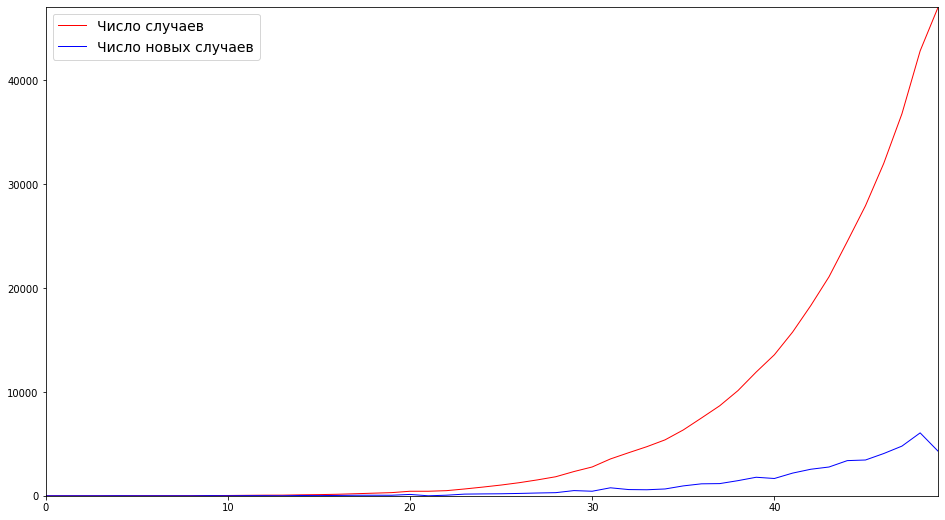

In [84]:
days = np.linspace(0,49,50)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlim((days[0], days[-1]))
ax.set_ylim((0, total[-1]))

ax.plot(days, total, linewidth=1, label="Число случаев", color="red")
ax.plot(days, new, linewidth=1, label="Число новых случаев", color="blue")

ax.legend(loc="upper left", fontsize=14)

plt.show()

Будем исходить из априорного распределения параметров y = exp{w0*x + w1} из N(0, a*I). Найдем параметры нормального апостериорного распределения p(w|D)

In [86]:
def create_X_matrix(n):
    t = range(0,2*n)
    t = np.array([ x/2 if x%2==0 else 1 for x in t])
    t= t.reshape(n,2)
    return t

In [87]:
import math

def param_function(a,b,d,N,X,y):
    A = b* (X.transpose()).dot(X) + np.eye(d) * a
    #print(A)
    m = b * np.linalg.inv(A).dot(X.transpose().dot(y))
    #print(m)
    return  .5 * d * math.log(a) \
            + .5*N * math.log(b) \
            - 0.5 * b * np.linalg.norm(y- X.dot(m)) ** 2  \
            - 0.5 * a * np.linalg.norm(m)**2 \
            - 0.5 * math.log(np.linalg.det(A)) 

Оптимизируем параметры a и b исходя из dataset числа заболевших

In [88]:
X = create_X_matrix(50)
total_exp = np.array([math.log(t) for t in total])

param_function(1,1,2,50,X,total_exp)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,total_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)


0.934448160535117 7.443143812709029 16.52761391495929


Найтем математическое ожидание апостериорного распредерения, для этого надо использовать регрессию Лассо с регуляризатором a/b

In [89]:
from sklearn import linear_model

model = linear_model.Lasso(alpha = best_a/best_b).fit(X, total_exp)

print("Среднее апостериорного распределения", model.coef_[0], model.intercept_)


Среднее апостериорного распределения 0.20267751811501739 1.4937265484644708


In [90]:
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Стандартное отклонение апостериорного распределения: 0.34549391102679233


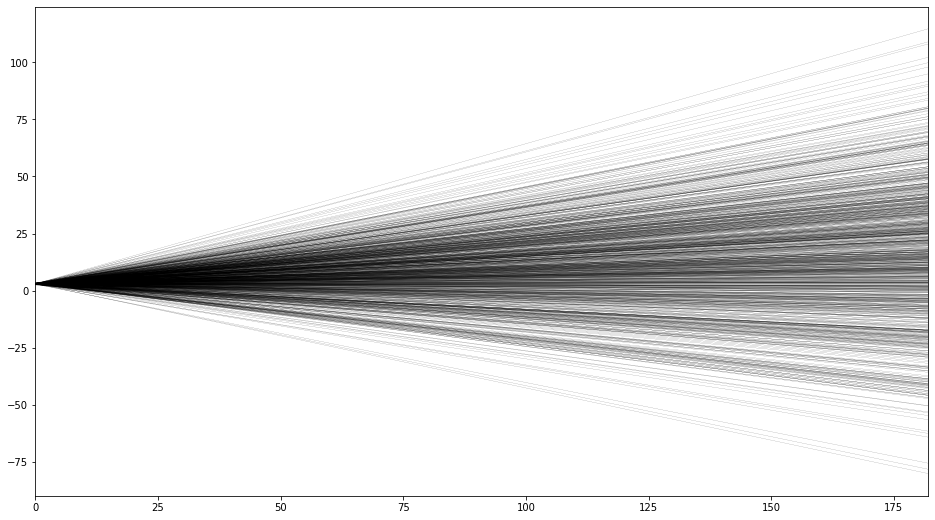

In [108]:
from scipy.stats import multivariate_normal
import datetime

mean = [model.coef_[0], model.intercept_]

def get_sample(mean, std_dev):
     return multivariate_normal.rvs(mean=mean, cov=np.eye(2)*std_dev**2)

days = np.linspace(0,100,101)


start = datetime.date(2020,3,3)
may_1 = (datetime.date(2020,5,1) - start).days
jun_1 = (datetime.date(2020,6,1) - start).days 
sep_1 = (datetime.date(2020,9,1) - start).days 

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

for i in range(0,1000):
    sample = get_sample(mean, std_dev)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
plt.show()


(array([  5.,   3.,  11.,  17.,  24.,  32.,  53.,  67.,  91.,  93.,  86.,
        107., 100.,  86.,  65.,  53.,  46.,  26.,  17.,  13.,   3.,   1.,
          1.]),
 array([-46.11071295, -40.69630213, -35.28189132, -29.86748051,
        -24.4530697 , -19.03865889, -13.62424808,  -8.20983727,
         -2.79542645,   2.61898436,   8.03339517,  13.44780598,
         18.86221679,  24.2766276 ,  29.69103841,  35.10544923,
         40.51986004,  45.93427085,  51.34868166,  56.76309247,
         62.17750328,  67.59191409,  73.00632491,  78.42073572]),
 <a list of 23 Patch objects>)

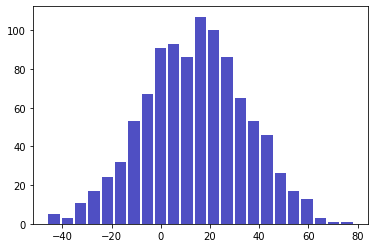

In [96]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 мая')

(array([  5.,   3.,  11.,  17.,  25.,  29.,  55.,  63.,  93.,  94.,  87.,
        105., 100.,  88.,  62.,  55.,  45.,  27.,  18.,  13.,   3.,   1.,
          1.]),
 array([-71.17363133, -62.92575932, -54.67788731, -46.4300153 ,
        -38.1821433 , -29.93427129, -21.68639928, -13.43852727,
         -5.19065526,   3.05721674,  11.30508875,  19.55296076,
         27.80083277,  36.04870477,  44.29657678,  52.54444879,
         60.7923208 ,  69.04019281,  77.28806481,  85.53593682,
         93.78380883, 102.03168084, 110.27955284, 118.52742485]),
 <a list of 23 Patch objects>)

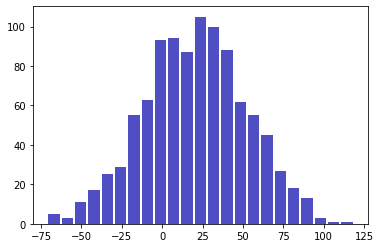

In [97]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 июня')

(array([  2.,   4.,   2.,   8.,   7.,  15.,  38.,  52.,  64.,  76.,  86.,
        107., 110., 111.,  86.,  83.,  41.,  41.,  31.,  14.,  10.,   5.,
          4.,   2.,   0.,   1.]),
 array([-174.1775213 , -156.80059067, -139.42366004, -122.04672941,
        -104.66979878,  -87.29286815,  -69.91593752,  -52.53900689,
         -35.16207626,  -17.78514563,   -0.408215  ,   16.96871563,
          34.34564626,   51.72257689,   69.09950752,   86.47643815,
         103.85336878,  121.23029941,  138.60723004,  155.98416067,
         173.3610913 ,  190.73802193,  208.11495256,  225.49188319,
         242.86881382,  260.24574445,  277.62267508]),
 <a list of 26 Patch objects>)

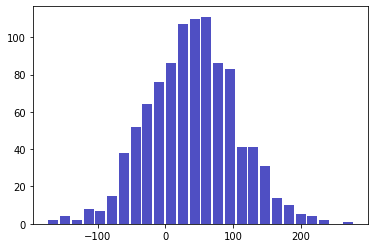

In [94]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 сентября')

Сделаем то же самое для new_cases

In [98]:
X = create_X_matrix(50)
new_exp = np.array([math.log(t) for t in new])

param_function(1,1,2,50,X,total_exp)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,new_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

36.81571906354515 1.4351170568561873 -20.28557221197176


In [101]:
model = linear_model.Lasso(alpha = best_a/best_b).fit(X, new_exp)

mean = [model.coef_[0], model.intercept_]
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Среднее апостериорного распределения [0.06794348147193136, 2.953479870799395]
Стандартное отклонение апостериорного распределения: 0.16168864949559822


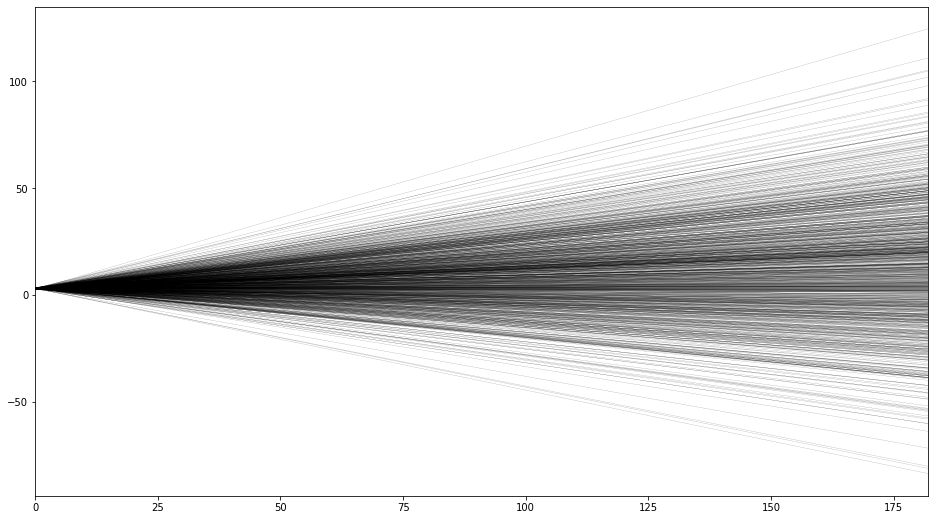

In [109]:
days = np.linspace(0,100,101)

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

for i in range(0,1000):
    sample = get_sample(mean, std_dev)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
plt.show()

(array([  1.,   1.,   8.,   2.,   8.,  19.,  30.,  31.,  58.,  65.,  85.,
        101., 112.,  94., 100.,  86.,  66.,  43.,  32.,  17.,  19.,   8.,
          6.,   5.,   3.]),
 array([-23.39419948, -21.02938363, -18.66456778, -16.29975192,
        -13.93493607, -11.57012022,  -9.20530437,  -6.84048852,
         -4.47567266,  -2.11085681,   0.25395904,   2.61877489,
          4.98359074,   7.3484066 ,   9.71322245,  12.0780383 ,
         14.44285415,  16.80767   ,  19.17248586,  21.53730171,
         23.90211756,  26.26693341,  28.63174926,  30.99656512,
         33.36138097,  35.72619682]),
 <a list of 25 Patch objects>)

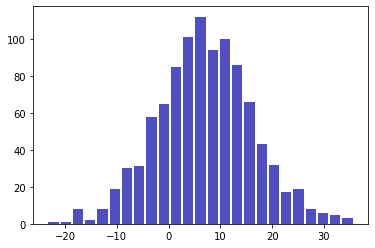

In [103]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 мая')

(array([  1.,   0.,   8.,   3.,   6.,  15.,  28.,  28.,  41.,  75.,  66.,
         87., 105., 100.,  91.,  96.,  77.,  55.,  41.,  24.,  18.,  14.,
          7.,   8.,   3.,   3.]),
 array([-37.32379407, -33.85009722, -30.37640037, -26.90270352,
        -23.42900667, -19.95530982, -16.48161297, -13.00791612,
         -9.53421927,  -6.06052242,  -2.58682557,   0.88687128,
          4.36056813,   7.83426498,  11.30796183,  14.78165868,
         18.25535553,  21.72905238,  25.20274923,  28.67644608,
         32.15014293,  35.62383978,  39.09753663,  42.57123348,
         46.04493033,  49.51862718,  52.99232403]),
 <a list of 26 Patch objects>)

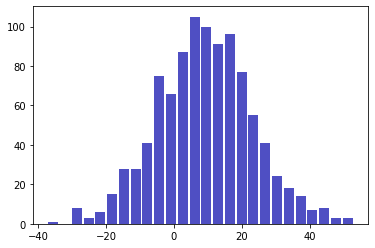

In [104]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 июня')

(array([  1.,   0.,   9.,   2.,   7.,  20.,  29.,  31.,  56.,  67.,  86.,
        101., 109.,  93., 105.,  87.,  65.,  43.,  31.,  19.,  17.,   8.,
          7.,   4.,   3.]),
 array([-78.66323606, -71.34735727, -64.03147847, -56.71559968,
        -49.39972088, -42.08384209, -34.76796329, -27.4520845 ,
        -20.13620571, -12.82032691,  -5.50444812,   1.81143068,
          9.12730947,  16.44318827,  23.75906706,  31.07494586,
         38.39082465,  45.70670345,  53.02258224,  60.33846103,
         67.65433983,  74.97021862,  82.28609742,  89.60197621,
         96.91785501, 104.2337338 ]),
 <a list of 25 Patch objects>)

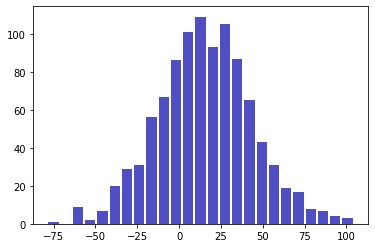

In [105]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 сентября')